# データをプロットしてみる

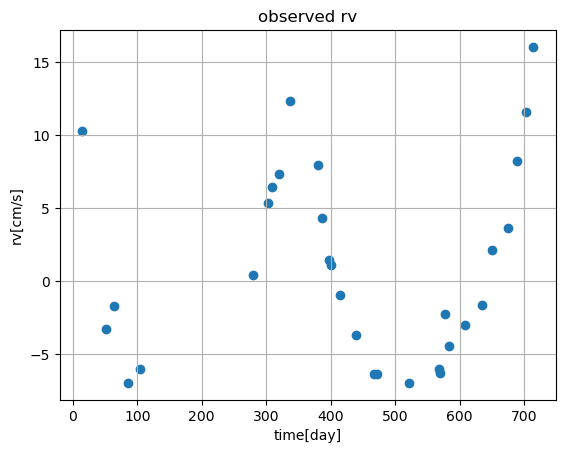

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('rvdata.txt')  # 与えられたデータ
t_obs = df['# tobs (day)'].to_numpy() # 時刻
rv_obs = df[' rv (cm/s)'].to_numpy() # 視線速度

plt.figure()
plt.xlabel("time[day]")
plt.ylabel("rv[cm/s]")
plt.scatter(t_obs,rv_obs)
plt.title("observed rv")
plt.grid()
plt.savefig('rv_observed.pdf')

# まず周期を解析する

chatgptを参考にLomb Scargle パワースペクトル解析を用いる

推定周期 P ≈ 370.5804 日


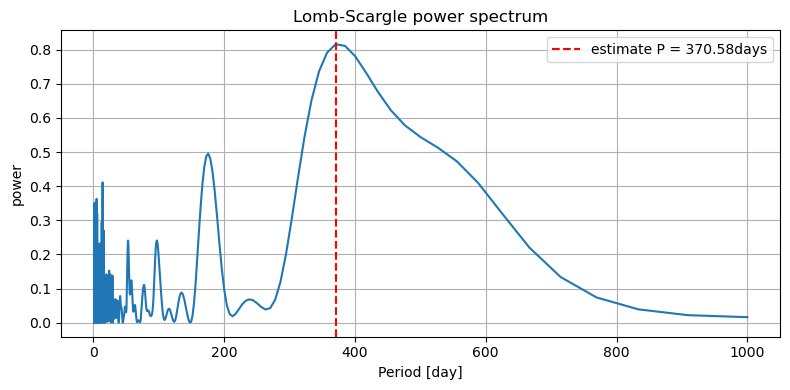

In [10]:
from astropy.timeseries import LombScargle

min_period = 1.0     # 日
max_period = 1000.0   # 日
frequency = np.linspace(1/max_period, 1/min_period, 10000)  # 周波数 [1/day]


# Lomb-Scargle 周期解析

ls = LombScargle(t_obs, rv_obs)
power = ls.power(frequency)


# 最も強いピークの周期
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency
print(f"推定周期 P ≈ {best_period:.4f} 日")


plt.figure(figsize=(8,4))
plt.plot(1/frequency, power)
plt.axvline(best_period, color='r', linestyle='--', label=f"estimate P = {best_period:.2f}days")
plt.xlabel("Period [day]")
plt.ylabel("power")
plt.title("Lomb-Scargle power spectrum")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('Lomb-Scargle_powerspectrum.pdf')

# 使う方程式の定義

\begin{align}
   f(E)&=E-e\sin E-M\\
   \mathrm{RV}&=V_\mathrm{sys}+K[\cos(\nu+\omega)+e\cos\omega]
\end{align}

ここで, $M=\dfrac{2\pi}{P}(t-T_0)$

In [11]:
import pytensor.tensor as pt
import pytensor


# f(E)=E-e\sin E-M からE(M)を求める. Newton法. 
# pytensor.scanを使う
def kepler_E_scan(M, e, tol=1e-10, maxiter=100):
    def newton_step(E_prev, M_, e_):
        f = E_prev - e_ * pt.sin(E_prev) - M_
        fprime = 1 - e_ * pt.cos(E_prev)
        E_next = E_prev - f / fprime
        return E_next

    def body_fn(i, E_prev, M_, e_):
        E_next = newton_step(E_prev, M_, e_)
        return E_next

    # 初期値 E0 = M
    E0 = M

    E_all, _ = pytensor.scan(
        fn=body_fn,
        sequences=pt.arange(maxiter),
        outputs_info=E0,
        non_sequences=[M, e]
    )

    return E_all[-1]


# rvの式
def rv_model_vec(t, P, K, e, omega, Vsys, T0):
    M = 2 * np.pi / P * (t - T0)
    M = pt.mod(M, 2 * np.pi)  
    E = kepler_E_scan(M, e)
    nu = 2 * pt.arctan2(pt.sqrt(1 + e) * pt.sin(E / 2),
                        pt.sqrt(1 - e) * pt.cos(E / 2))
    return Vsys + K * (pt.cos(nu + omega) + e * pt.cos(omega))

# ベイズ推定

### 事前分布の設定

$P$: 周期解析によって平均を370にして正規分布で考える. 分散は適当.

$K$: chatgptの結果を参考に正規分布.

$e$: 束縛系の条件$0\leq e<1$の中で一様.

$\omega$: 位相0~$2\pi$の中で一様.

$V_\mathrm{sys}$: chatgptの結果を参考に正規分布.

$T_0$: 周期を覆うように一様分布. 


In [17]:
t = t_obs


import pymc as pm

with pm.Model() as model:
    # 事前分布
    P = pm.Normal('P', mu=370, sigma=20)
    K = pm.Normal('K', mu=11, sigma=2)
    e = pm.Uniform('e', lower=0, upper=1)
    omega = pm.Uniform('omega', lower=0, upper=2*np.pi)
    Vsys = pm.Normal('Vsys', mu=0, sigma=30)
    T0 = pm.Uniform('T0', lower=-200, upper=200)
    noise = pm.HalfCauchy('noise', beta=5)

    # 尤度
    y = rv_model_vec(t, P, K, e, omega, Vsys, T0)

    rv_pred = pm.Normal('rv_pred', mu=y, sigma=noise, observed=rv_obs)

    # サンプリング
    trace = pm.sample(5000, chains=1,target_accept=0.9, tune=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P, K, e, omega, Vsys, T0, noise]


/Users/kikuchitaiki/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 149 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


求まるパラメータの分布

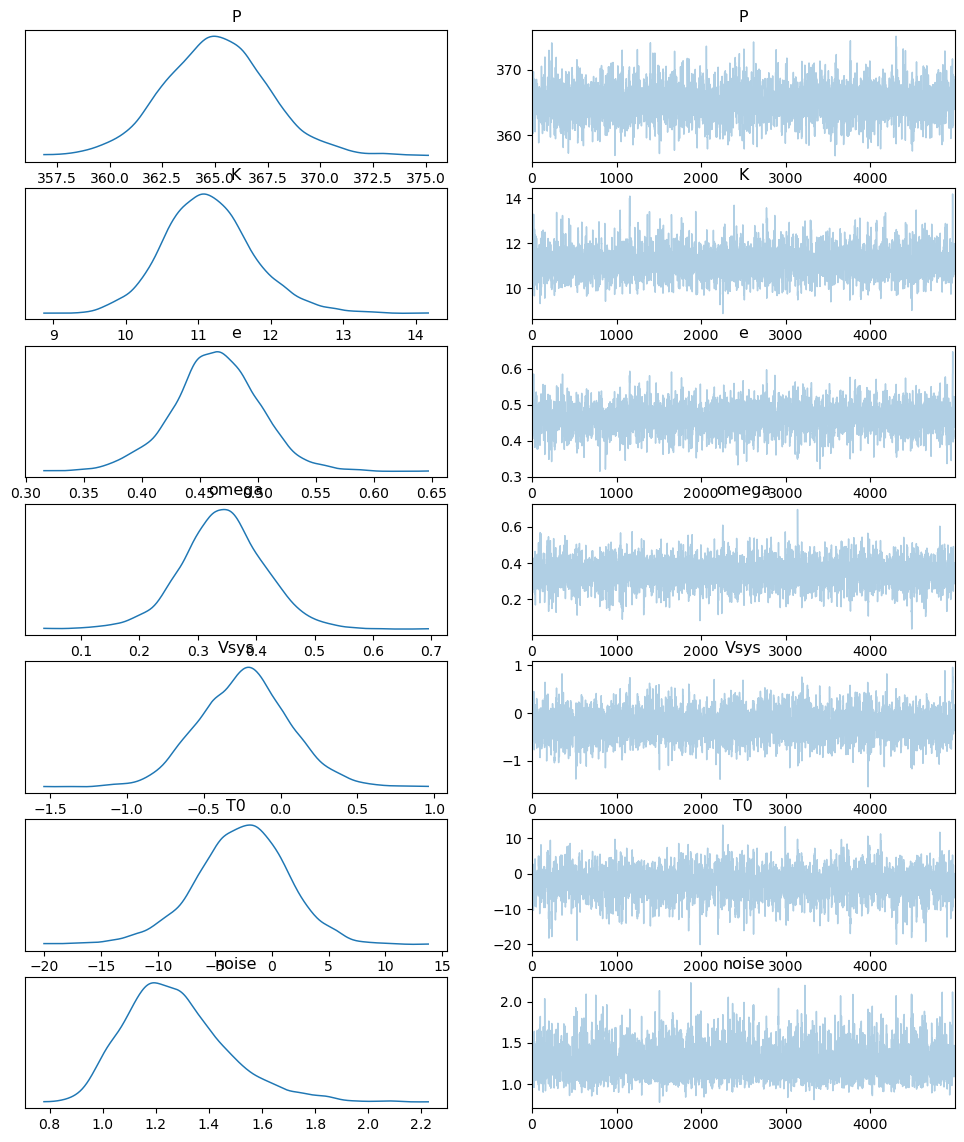

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P,365.042,2.478,360.318,369.750,0.052,0.041,2277.0,2432.0,NaN
K,11.151,0.632,9.915,12.319,0.013,0.012,2287.0,2176.0,NaN
e,0.464,0.038,0.387,0.530,0.001,0.001,2123.0,2387.0,NaN
omega,0.342,0.072,0.203,0.477,0.002,0.002,2370.0,1980.0,NaN
Vsys,-0.238,0.294,-0.779,0.322,0.006,0.005,2585.0,2667.0,NaN
T0,-2.731,4.129,-10.485,5.233,0.103,0.086,1673.0,1857.0,NaN
noise,1.276,0.195,0.951,1.651,0.004,0.004,3107.0,3117.0,NaN


In [19]:
import arviz as az

az.plot_trace(trace, var_names=['P', 'K', 'e', 'omega', 'Vsys', 'T0', 'noise'])
plt.savefig('params_distribution.pdf')
plt.show()

az.summary(trace, var_names=['P', 'K', 'e', 'omega', 'Vsys', 'T0', 'noise'])

# 観測データとの比較, モデルの分布

Sampling: [rv_pred]


/Users/kikuchitaiki/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/var/folders/pv/68c56c_d7_3gzv7n8wjb5q1c0000gn/T/ipykernel_82500/2655431119.py:14: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_68 = az.hdi(rv_pred_samples_sorted, hdi_prob=0.68)
/var/folders/pv/68c56c_d7_3gzv7n8wjb5q1c0000gn/T/ipykernel_82500/2655431119.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_95 = az.hdi(rv_pred_samples_sorted, hdi_prob=0.95)


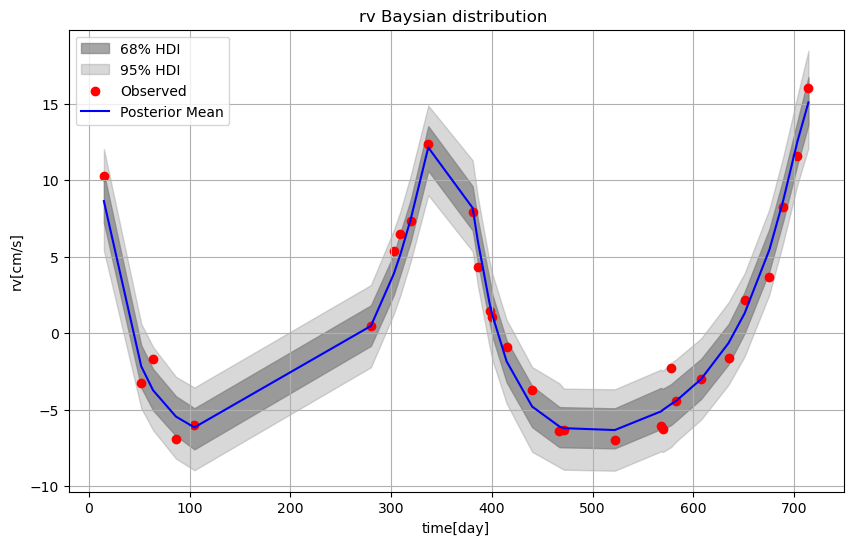

In [25]:
with model:
    ppc = pm.sample_posterior_predictive(trace, progressbar=True)

# t を昇順にソートして見やすくする
idx = np.argsort(t)
t_sorted = t[idx]

rv_pred_samples = ppc.posterior_predictive["rv_pred"].values  # shape: (chains, draws, obs)
# chainsとdrawsをまとめて2次元に
rv_pred_samples = rv_pred_samples.reshape(-1, rv_pred_samples.shape[-1])
rv_pred_samples_sorted = rv_pred_samples[:, idx]

# HDI（信頼区間）計算
hdi_68 = az.hdi(rv_pred_samples_sorted, hdi_prob=0.68)
hdi_95 = az.hdi(rv_pred_samples_sorted, hdi_prob=0.95)

plt.figure(figsize=(10,6))
plt.fill_between(t_sorted, hdi_68[:, 0], hdi_68[:, 1], color='gray', alpha=0.7, label="68% HDI")
plt.fill_between(t_sorted, hdi_95[:, 0], hdi_95[:, 1], color='gray', alpha=0.3, label="95% HDI")
plt.scatter(t, rv_obs, color='red', label='Observed')
plt.plot(t_sorted, rv_pred_samples_sorted.mean(axis=0), color='blue', label='Posterior Mean')

plt.xlabel("time[day]")
plt.ylabel("rv[cm/s]")

plt.legend()
plt.grid()
plt.title("rv Baysian distribution ")
plt.savefig('rv_fitted.pdf')
plt.show()


# 設問(b) $M_p\sin i$の計算

mean:1.1020, var:0.0489


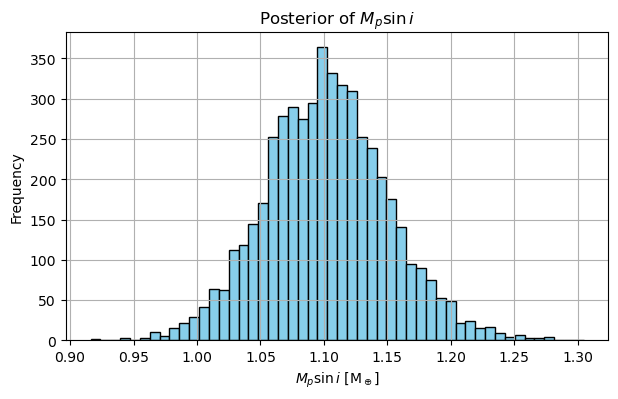

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# 物理定数(cgs)
G = 6.67430e-8        
M_sun = 1.9885e33      
M_jup = 1.89813e30     
M_earth = 5.972e27

# 設定
M_star = 1.0 * M_sun

# posterior サンプルの取得
posterior = trace.posterior
K_samples = posterior["K"].values.flatten() 
P_samples = posterior["P"].values.flatten() * 86400    # days → seconds
e_samples = posterior["e"].values.flatten()


# Mpsiniの計算
mpsini_g = K_samples * np.sqrt(1 - e_samples**2) * M_star**(2/3)*P_samples**(1/3) / (2*np.pi*G)**(1/3)


mpsini_Mear = mpsini_g / M_earth # 地球質量に換算

mean_mpsini, var_mpsini = np.mean(mpsini_Mear), np.std(mpsini_Mear, ddof=1)
print(f"mean:{mean_mpsini:.4f}, var:{var_mpsini:.4f}")

# プロット
plt.figure(figsize=(7, 4))
plt.hist(mpsini_Mear, bins=50, color='skyblue', edgecolor='k')
plt.xlabel(r"$M_p \sin i$ [M$_\oplus$]")
plt.ylabel("Frequency")
plt.title("Posterior of $M_p \sin i$")
plt.grid()
plt.show()
